In [572]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy
from imageio import imread
from itertools import compress
import skimage.io as io
import skimage.transform as trans
from skimage import util 
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import *
np.set_printoptions(threshold=np.inf)
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2.3.1


In [573]:
train_images_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Images/Train/'
train_masks_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Masks/Train/'

test_images_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Images/Test/'
test_masks_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Masks/Test/'
# Modify before running
shared_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Results/Images/PhysicalLayer'
results_path = shared_path+'/' 
#os.mkdir(results_path+'Images')
images_path = results_path+'Images/' #change kernel size number
model_name = 'Dual_Input_Unet_Model_withPL.h5 '



In [574]:
def filename_grabber(image_path = None, extensions = ['bmp']):
    """
   Grabs files names from directory and returns a list of their names
    
    Parameters
    ----------
    image_path : string
        Full file path that leads to image directory
        
    extensions : list of strings
        string of file extensions, without a period, within a list

    Returns
    -------
    file_names_images : list
        List of all specified files with predefined extensions 
        
    Notes
    -----
    """
    file_names_images = [fn for fn in os.listdir(image_path)
        if any(fn.endswith(ext) for ext in extensions)]
    file_names_images.sort()
    return file_names_images




In [575]:
# CANNY IMAGE NAAMES & MASKS
included_extensions = ['bmp']
train_images_names = filename_grabber(train_images_path)
train_masks_names = filename_grabber(train_masks_path)


test_images_names = filename_grabber(test_images_path)
test_masks_names = filename_grabber(test_masks_path)

In [576]:
# print(len(file_names_images))
print(len(train_images_names))
print(len(train_masks_names))

print(len(test_images_names))
print(len(test_masks_names))

1040
1040
80
80


Preallocate Image Matrices, Read & Crop them

In [577]:
size = 160

train_images = np.zeros((len(train_images_names),160,size, 1)).astype('float')
Nimages = np.zeros((len(train_images_names),160,size, 1)).astype('float')

for i in range(len(train_images_names)):
    train_image = imread(train_images_path+train_images_names[i], as_gray=True)/255


    train_image = train_image[..., None] # adds a channel layer
    train_images[i] = train_image[1:,:-1] # adds subsequent image arrays to img matrix
    
print(train_images.shape)


(1040, 160, 160, 1)


In [578]:
size = 160

test_images = np.zeros((len(test_images_names),160,size, 1)).astype('float')
Nimages = np.zeros((len(test_images_names),160,size, 1)).astype('float')

for i in range(len(test_images_names)):
    test_image = imread(test_images_path+test_images_names[i], as_gray=True)/255


    test_image = test_image[..., None] # adds a channel layer
    test_images[i] = test_image[1:,:-1] # adds subsequent image arrays to img matrix
    
print(test_images.shape)

(80, 160, 160, 1)


In [579]:
# GRAB ALL MASK IMAGES & CROP
train_masks = np.zeros((len(train_images_names), 160, size, 1)).astype('float')
for i in range(len(train_images_names)):
    train_mask = imread(train_masks_path+train_masks_names[i], as_gray=True)/255
    minimum = train_masks.min()
    train_mask = np.where(train_mask==minimum, 0, 1)
    train_mask = train_mask[..., None]
    train_masks[i] = train_mask[1:,:-1] # adds subsequent image arrays to img matrix


print(train_masks.shape)

(1040, 160, 160, 1)


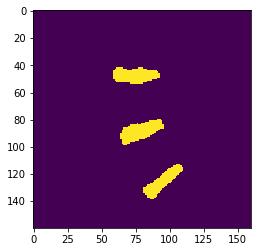

In [580]:
plt.imshow(np.sum(train_images[100],axis=2))
plt.imshow(np.sum(train_masks[100],axis=2))

In [581]:
# GRAB ALL MASK IMAGES & CROP
test_masks = np.zeros((len(test_images_names), 160, size, 1)).astype('float')
for i in range(len(test_images_names)):
    test_mask = imread(test_masks_path+test_masks_names[i], as_gray=True)/255
    minimum = test_mask.min()
    test_mask = np.where(test_mask==minimum, 0, 1)
    test_mask = test_mask[..., None]
    test_masks[i] = test_mask[1:,:-1] # adds subsequent image arrays to img matrix


print(test_masks.shape)

(80, 160, 160, 1)


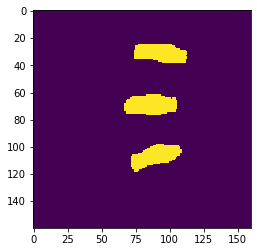

In [582]:
plt.imshow(np.sum(test_images[30],axis=2))
plt.imshow(np.sum(test_masks[30],axis=2))

In [583]:
def get_dataset(images, mask, batch_size, shuffle = True):
    a = np.shape(images)
    if a[0] ==2:
        im1 = images[0]
        im2 = images[1]
        dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(im1, dtype=tf.float32))
        dataset_input2 = tf.data.Dataset.from_tensor_slices(tf.constant(im2, dtype=tf.float32))
        dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32))

        dataset = tf.data.Dataset.zip(((dataset_input,dataset_input2) , dataset_mask))
    else:    
        dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(images, dtype=tf.float32))
        dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32))
        dataset_input = dataset_input.map(lambda x: tf.image.per_image_standardization(x))
        dataset_input = dataset_input.map(lambda x: tf.image.adjust_contrast(x,1.2))
        dataset = tf.data.Dataset.zip((dataset_input, dataset_mask))

    if shuffle == True:
        
        dataset = dataset.shuffle(len(images)).repeat() #randomly shuffles dataset and repeats the dataset
    else:
        dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size).prefetch(batch_size)

    print(dataset)
    return dataset


In [584]:
train_dataset = get_dataset(images = train_images, mask = train_masks,batch_size =  10, shuffle = True)
test_dataset = get_dataset(images = test_images, mask = test_masks,batch_size =  10, shuffle = False)

<PrefetchDataset shapes: ((None, 160, 160, 1), (None, 160, 160, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 160, 160, 1), (None, 160, 160, 1)), types: (tf.float32, tf.float32)>


In [585]:
IMG_HEIGHT = 160
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 1

In [775]:
# build the physical layer - gamma correction
gamma_init=0.9
gain_init=1.0
class GammaCorrection(tf.keras.layers.Layer):
    def __init__(self):#, gamma_init, gain_init):
        super(GammaCorrection, self).__init__()
#         self.gamma = gamma
#         self.gain = gain
        self.adjustment = 5e-7

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.gamma = tf.Variable(initial_value = gamma_init, 
                              trainable = True, dtype=tf.float32)
        self.gain = tf.Variable(initial_value = gain_init, 
                              trainable = True, dtype=tf.float32)
        
        super(GammaCorrection, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, images):
        #set limits on gamma and gain
        #When gamma  <  1,  the  enhanced  image  will  be  brighter  than  the  original image, 
        #when gamma > 1 image will  be  darker  than  the  original image
        gamma_out = 0.8 + 0.4 * tf.sigmoid(self.gamma*self.adjustment)
            
        gain_out = 0.8 + 0.4 * tf.sigmoid(self.gain)
        
        scale = 1.0
        out = (((images / scale) ** gamma_out) * scale * gain_out)
        
        return out

In [776]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

phys = GammaCorrection()(s)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (phys)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [777]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_251"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_162 (InputLayer)          [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
lambda_98 (Lambda)              (None, 160, 160, 1)  0           input_162[0][0]                  
__________________________________________________________________________________________________
gamma_correction_150 (GammaCorr (None, 160, 160, 1)  2           lambda_98[0][0]                  
__________________________________________________________________________________________________
conv2d_2867 (Conv2D)            (None, 160, 160, 32) 320         gamma_correction_150[0][0]       
_____________________________________________________________________________________

In [778]:
def unet(pretrained_weights = None, input_size = (160,160,1), df=8, kernel_size = 3): 
    
    """
    Initiliazed a Keras implementation of Unet as defined previously by Ronnenburger et al., 2015
    
    Parameters
    ----------
    pretrained_weights : hdf5
        Keras model file from pretrained Unet
        
    input_size : tuple
        A tuple specifying the input (image) size in form (rows,columns,channels)
        
    df : int
        # of filters to include in first convolutional layer. # expands by 2 for each conv. level
   
   kernel_size : int
        Specifies filter size. Kernels are square (nxn).
    Returns
    -------
    model : h5
        untrained Keras model structure
        
    Notes
    -----
    """
    inputs = Input(input_size)
    
    phys = GammaCorrection()(inputs)
    
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(phys)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(df*2*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(df*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(df*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(df, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [779]:
model = unet(df=8, input_size=(160, size, 1), kernel_size=5)
y = model.count_params()

In [780]:
batch_size = 4
batch_size_test = 1
steps_epoch = np.int16(np.ceil(len(train_images)/batch_size))
steps_val = np.int16(np.ceil(len(train_images)/batch_size_test))

In [781]:
history = model.fit( x = train_dataset ,validation_data=  test_dataset, validation_steps=steps_val, epochs=5, verbose=1,steps_per_epoch=steps_epoch)

Epoch 1/5
260/260 [==============================] - 476s 2s/step - loss: 0.0769 - accuracy: 0.9703 - val_loss: 0.0398 - val_accuracy: 0.9750
Epoch 2/5
260/260 [==============================] - 477s 2s/step - loss: 0.0278 - accuracy: 0.9900 - val_loss: 0.0451 - val_accuracy: 0.9873
Epoch 3/5
260/260 [==============================] - 596s 2s/step - loss: 0.0252 - accuracy: 0.9956 - val_loss: 0.0466 - val_accuracy: 0.9884
Epoch 4/5
260/260 [==============================] - 491s 2s/step - loss: 0.0243 - accuracy: 0.9964 - val_loss: 0.0443 - val_accuracy: 0.9898
Epoch 5/5
260/260 [==============================] - 476s 2s/step - loss: 0.0236 - accuracy: 0.9969 - val_loss: 0.0578 - val_accuracy: 0.9887


<tf.Variable 'gamma_correction_151/Variable:0' shape=() dtype=float32, numpy=0.8999855>
<tf.Variable 'gamma_correction_151/Variable:0' shape=() dtype=float32, numpy=1.0011914>


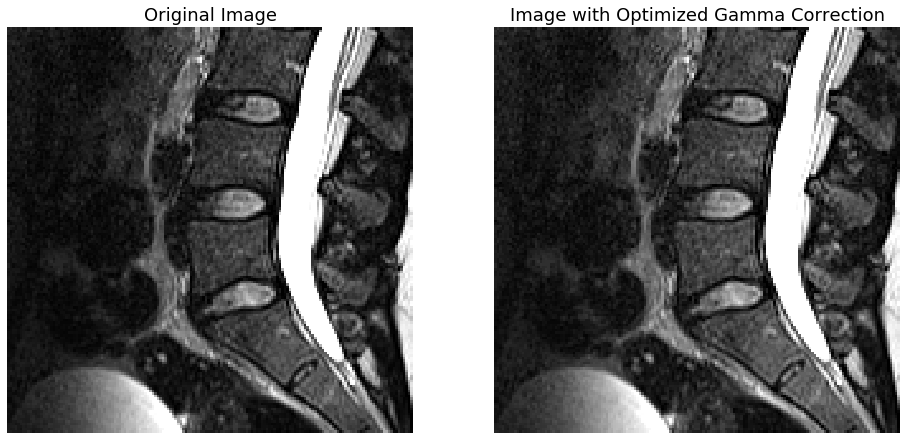

In [788]:
# visualize learned gamma correction
learned_gamma = model.trainable_weights[0]
learned_gain = model.trainable_weights[1]
print(learned_gamma)
print(learned_gain)

vis_im = tf.image.adjust_gamma(test_images,learned_gamma)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
ax1.imshow(np.sum(test_images[30],axis=2), cmap='gray')
ax1.set_title('Original Image', size=18)
ax1.axis('off')
ax2.imshow(np.sum(vis_im[30],axis=2), cmap='gray')
ax2.set_title('Image with Optimized Gamma Correction', size=18)
ax2.axis('off')

plt.savefig(os.path.join('/Volumes/dusom_ortho_research/Private/DefratePrivate/',
                         'Spine R01/AutoSegmentation/Results/Images/Figures/PL_visual.png'), transparent=True)

In [789]:
# threshold images to consistent value of 0.5 (everything above becomes 1 for bone)
results = model.predict(test_dataset, verbose=0, steps=steps_val)
results_thresh = results
threshold_val = 0.5
threshold_indices_1 = results_thresh > threshold_val
threshold_indices_0 = results_thresh <= threshold_val
results_thresh[threshold_indices_1] = 1
results_thresh[threshold_indices_0] = 0

In [794]:
def plot_examples(batch):
    plt.figure(figsize=(15, 15))
    for i in range(len(batch)):
        plt.subplot(8, 8, i+1)
        plt.imshow(batch[i])
#         plt.colorbar()
#         plt.axis('off')
        plt.gray()
    plt.show()

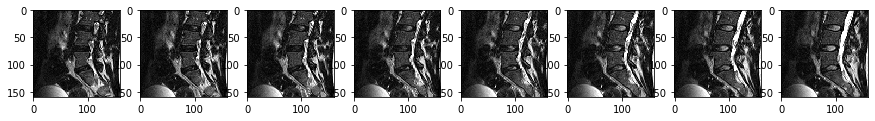

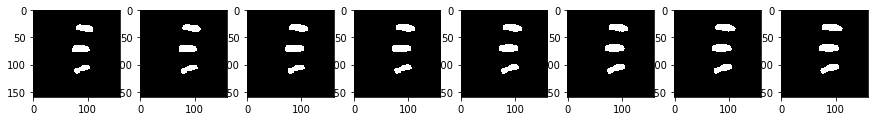

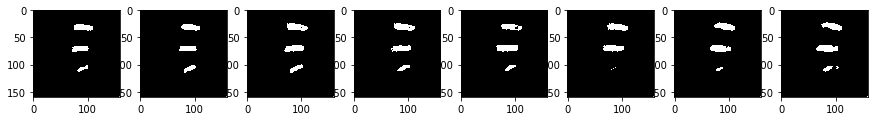

In [796]:
plot_examples(np.sum(test_images[14:22],axis=3)) # display the test images
plot_examples(np.sum(test_masks[14:22],axis=3)) # display the test masks
plot_examples(np.sum(results_thresh[14:22], axis=3)) # display thresholded images

In [791]:
# export images
for i in range(len(test_images)):
    io.imsave(os.path.join(results_path,'Pred/', 
                           'predictedmask.'+str(i)+'.bmp'),results_thresh[i])
    io.imsave(os.path.join(results_path,'X/', 
                           'X_test.'+str(i)+'.bmp'),test_images[i])
    io.imsave(os.path.join(results_path,'Y/', 
                           'y_test.'+str(i)+'.bmp'),test_masks[i])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0